# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project we have attempted to detect lane lines on road both for images as well as videos using Python, OpenCV and other Python libraries like Numpy, Matplotlib and Sympy.


**Chundi Himakiran Kumar**

## Import Packages

In [267]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


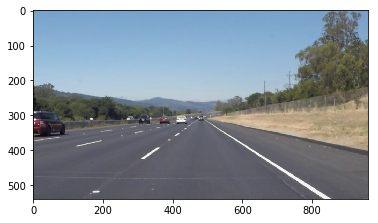

In [268]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image);  # if you wanted to show a single color channel image called 'gray', 
                    #for example, call as plt.imshow(gray, cmap='gray')
                    # The semicolon does away with the image title

## Helper Functions

We have used all the given helper functions for our task without any change to their code

In [269]:
import math
#Importing sympy to help with slope calculation later
from sympy.geometry import *

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Draw_Lines
***
This is the function where we take the lines and  the image as the input and draw the lines over the image.

---

In [295]:
def draw_lines(img, lines, color=[0, 0, 255], thickness=12):
    """
    This function accepts lines and image as the input and  draws the lane line over the image
    
    """    
    # Separating the x and y points of all lines
    # Initialising the x and y point arrays for both the lanes
    x_left = []
    y_left = []
    x_right = []
    y_right = []
    
    # We calculate the slope using sympy and depending on the sign of the slope we add points
    # to the respective arrays
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            A = Point2D(x1,y1)
            B = Point2D(x2,y2)
            S1 = Segment(A,B)
            SLOPE = S1.slope
            if (SLOPE < 0):
                x_left += [x1,x2]
                y_left += [y1,y2]
            else:
                x_right += [x1,x2]
                y_right += [y1,y2]
                
    # Using numpy polyfit to fit the points in left lane
    
    # Avoiding empty lists..
    if((np.array(x_left).size == 0)|((np.array(y_left).size == 0))):
        return
    
    z = np.polyfit(x_left, y_left, 1)
    
    # retrieve the slope and intercept
    m_left,b_left = z
    
    #finding the start and the end point of the left lane
    x1 = min(x_left)
    y1 = int(m_left*x1+b_left)
    x2 = max(x_left)
    y2 = int(m_left*x2 + b_left)

    
    # Avoiding empty lists..
     
    if((np.array(x_right).size == 0)|((np.array(y_right).size == 0))):
        return
    
    # Using numpy polyfit to fit the points in right lane
    
    # retrieve the slope and intercept    
    z = np.polyfit(x_right, y_right, 1)
    
    # retrieve the slope and intercept
    m_right,b_right = z
    
    #finding the start and the end point of the right lane
    xx1 = min(x_right)
    yy1 = int(m_right*xx1+b_right)
    xx2 = max(x_right)
    yy2 = int(m_right*xx2 + b_right)

    # Extrapolation
    
    # To extrapolate we shall choose the start point y co-ord as the min of y_left and y_right
    # This should give us the y coord of the respective start point of the two lanes 
    y_left_min = min(y_left)
    y_right_min = min(y_right)
    
    #Now we find which of them is the minimum of the two. We do this so that we can draw both the lanes
    #from the same height so that they appear to meet in the distance.
    # This also selects the y coord of the start point of the solid lane
    vertex_y = min([y_left_min,y_right_min])
    
    # Depending on which of the lanes gives us the y-coord we find both lanes x and y coord of the start points    
    if(vertex_y == y_left_min):
        vertex_y_left = vertex_y
        vertex_x_left = int((vertex_y_left - b_left)/m_left)
        vertex_y_right = vertex_y
        vertex_x_right = int((vertex_y_right - b_right)/m_right)
    else:
        vertex_y_right = vertex_y
        vertex_x_right = int((vertex_y_right - b_right)/m_right)
        vertex_y_left = vertex_y
        vertex_x_left = int((vertex_y_left - b_left)/m_left)

    # to extrapolate the end points we shall set the y coord to 540 and calculate the x coords
    # Here we are hard-coding the image height and length.
    # We could also take the img as the input to this function and use its shape to detect the image
    # height and length
    IMG_HEIGHT = 540 
    IMG_LENGTH = 960
    
    end_y = IMG_HEIGHT
    end_x_left = int((end_y - b_left)/m_left)
    end_x_right = int((end_y - b_right)/m_right)

    # Avoiding abnormal values
    if ((vertex_x_left > 900) | (vertex_x_right > 900) | (vertex_y_left > 540) | (vertex_y_right > 540) ):
        return
    if ((end_x_left > 900) | (end_x_right > 900) | (end_y > 540) ):
        return
    
    # Now we draw both the lanes..We are using try and except clause to detect abnormal x and y values
    try:
        cv2.line(img, (vertex_x_left, vertex_y_left), (end_x_left, end_y), color, thickness)
        cv2.line(img, (vertex_x_right, vertex_y_right), (end_x_right, end_y), color, thickness)
    except:
        print("vertex_x_left : "+ str(vertex_x_left)+" vertex_y_left : "+ str(vertex_y_left))
        print("end_x_left : "+ str(end_x_left)+" end_y : "+ str(end_y))
        print("vertex_x_right : "+ str(vertex_x_right)+" vertex_y_right : "+ str(vertex_y_right))
        print("end_x_right : "+ str(end_x_right)+" end_y : "+ str(end_y))
        
    

## Test Images

  
**We shall first check our pipeline and the efficacy of the draw_lines fucntion by drawing lanes on the 
test images and saving the output in test_images_output directory as also viewing them inline**

In [296]:
import os
test_images = os.listdir("test_images/")

## Build a Lane Finding Pipeline



**Here in we build the pipeline and draw the lanes on test images and save the output images in test_images_output
directory as also view them inline**

In [297]:
# The below function implements the pipeline
def draw_line_on_image(img):
    
    # Read in and grayscale the image
    gray_img = grayscale(img)
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray_img,kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 100
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # Masking the result of Canny edge detection
    imshape=img.shape
    vertices = np.array([[(50,imshape[0]),(400, 350), (500, 350), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges,vertices)
    
    # Passing the masked image to Hough transform to draw the lines
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 #minimum number of pixels making up a line
    max_line_gap = 300   # maximum gap in pixels between connectable line segments
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    w_image = weighted_img(line_image, img, α=0.8, β=1., γ=0.)
    
    return w_image



## Testing the pipeline on test images

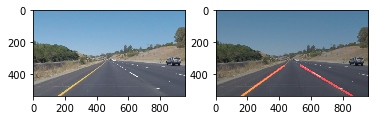

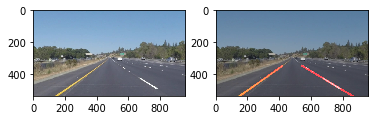

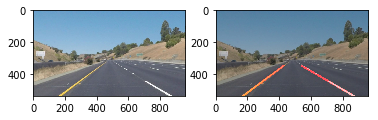

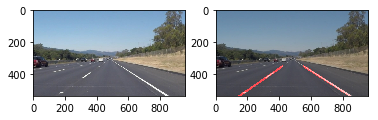

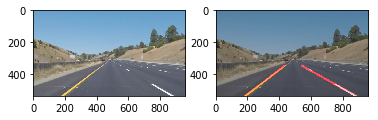

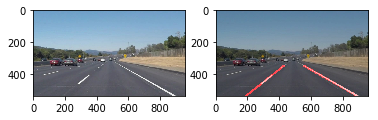

In [298]:
# Implementing a loop to call the pipeline on each image and then save and view the result

for each in test_images:
    # Read in and show the original image for comparison
    image = cv2.imread("test_images/"+each)
    
    # We  get an openCV error sometimes..see stackoverflow below
    # https://stackoverflow.com/questions/52739143/opencv-error-215assertion-failed-vscncontainsscn-vdcncontainsdcn
    image = image.astype('uint8')
    
    # code to show images side by side
    f, axarr = plt.subplots(1,2)
    
    #OpenCV works on BGR
    RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axarr[0].imshow(RGB_img);
    
    # Save and view the output image
    result_image = draw_line_on_image(image)    
    RGB_img = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
    axarr[1].imshow(RGB_img);
    cv2.imwrite("test_images_output/"+each +"-LD"+".jpg", result_image)

## Testing the pipeline on Videos


In [299]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML



In [300]:

def process_image(image):
    
    # This function outputs the result of the pipeline
    image = image.astype('uint8')
    result_image = draw_line_on_image(image)
    result_image = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)    
    return result_image

## Testing the pipeline on solid white lane on the right first ...

In [301]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) 
# Saving the output video
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4
















  0%|          | 0/222 [00:00<?, ?it/s]













  1%|▏         | 3/222 [00:00<00:08, 24.86it/s]













  3%|▎         | 7/222 [00:00<00:07, 27.09it/s]













  5%|▌         | 12/222 [00:00<00:06, 30.38it/s]













  7%|▋         | 16/222 [00:00<00:06, 31.85it/s]













  9%|▉         | 20/222 [00:00<00:06, 32.24it/s]













 11%|█         | 24/222 [00:00<00:06, 29.53it/s]













 13%|█▎        | 28/222 [00:00<00:06, 31.54it/s]













 14%|█▍        | 32/222 [00:00<00:05, 32.97it/s]













 16%|█▌        | 36/222 [00:01<00:05, 32.87it/s]













 18%|█▊        | 40/222 [00:01<00:06, 26.61it/s]













 19%|█▉        | 43/222 [00:01<00:07, 24.00it/s]













 21%|██        | 46/222 [00:01<00:07, 22.86it/s]













 22%|██▏       | 49/222 [00:01<00:10, 15.96it/s]













 23%|██▎       | 51/222 [00:02<00:10, 16.84it/s]













 24%|██▍       | 53/222 [00:02<00:10, 16.42it/s]













 25%|

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 6.05 s, sys: 747 ms, total: 6.8 s
Wall time: 11.4 s


## Playing the video inline

In [302]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Testing the pipeline on solid yellow lane on the left. 

In [303]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4
















  0%|          | 0/682 [00:00<?, ?it/s]













  0%|          | 3/682 [00:00<00:24, 28.03it/s]













  1%|          | 7/682 [00:00<00:22, 30.34it/s]













  2%|▏         | 11/682 [00:00<00:20, 32.02it/s]













  2%|▏         | 15/682 [00:00<00:20, 32.92it/s]













  3%|▎         | 19/682 [00:00<00:19, 33.84it/s]













  3%|▎         | 23/682 [00:00<00:18, 35.39it/s]













  4%|▍         | 27/682 [00:00<00:21, 29.87it/s]













  5%|▍         | 31/682 [00:00<00:20, 31.16it/s]













  5%|▌         | 35/682 [00:01<00:20, 32.17it/s]













  6%|▌         | 39/682 [00:01<00:19, 32.82it/s]













  6%|▋         | 43/682 [00:01<00:19, 33.63it/s]













  7%|▋         | 47/682 [00:01<00:24, 25.41it/s]













  7%|▋         | 50/682 [00:01<00:25, 24.74it/s]













  8%|▊         | 53/682 [00:01<00:27, 22.76it/s]













  8%|▊         | 56/682 [00:01<00:28, 21.69it/s]













  9%|

 36%|███▌      | 245/682 [00:10<00:20, 21.72it/s]













 36%|███▋      | 248/682 [00:10<00:20, 21.03it/s]













 37%|███▋      | 251/682 [00:10<00:20, 20.58it/s]













 37%|███▋      | 254/682 [00:11<00:22, 18.90it/s]













 38%|███▊      | 256/682 [00:11<00:22, 18.70it/s]













 38%|███▊      | 258/682 [00:11<00:23, 18.07it/s]













 38%|███▊      | 260/682 [00:11<00:24, 17.50it/s]













 38%|███▊      | 262/682 [00:11<00:23, 18.16it/s]













 39%|███▊      | 264/682 [00:11<00:23, 18.11it/s]













 39%|███▉      | 266/682 [00:11<00:22, 18.12it/s]













 39%|███▉      | 268/682 [00:11<00:22, 18.10it/s]













 40%|███▉      | 270/682 [00:12<00:22, 18.32it/s]













 40%|███▉      | 272/682 [00:12<00:23, 17.79it/s]













 40%|████      | 275/682 [00:12<00:21, 19.00it/s]













 41%|████      | 277/682 [00:12<00:21, 18.66it/s]













 41%|████      | 279/682 [00:12<00:22, 18.03it/s]







 63%|██████▎   | 428/682 [00:20<00:12, 19.76it/s]













 63%|██████▎   | 431/682 [00:20<00:12, 19.69it/s]













 63%|██████▎   | 433/682 [00:20<00:12, 19.61it/s]













 64%|██████▍   | 435/682 [00:20<00:13, 18.37it/s]













 64%|██████▍   | 437/682 [00:20<00:13, 18.71it/s]













 64%|██████▍   | 439/682 [00:20<00:13, 18.32it/s]













 65%|██████▍   | 441/682 [00:21<00:13, 17.84it/s]













 65%|██████▍   | 443/682 [00:21<00:13, 18.31it/s]













 65%|██████▌   | 446/682 [00:21<00:12, 19.58it/s]













 66%|██████▌   | 448/682 [00:21<00:13, 17.65it/s]













 66%|██████▌   | 451/682 [00:21<00:12, 18.48it/s]













 66%|██████▋   | 453/682 [00:21<00:12, 18.57it/s]













 67%|██████▋   | 456/682 [00:21<00:11, 19.47it/s]













 67%|██████▋   | 458/682 [00:21<00:11, 18.70it/s]













 67%|██████▋   | 460/682 [00:22<00:11, 18.77it/s]













 68%|██████▊   | 462/682 [00:22<00:12, 18.18it/s]







 90%|█████████ | 614/682 [00:30<00:04, 14.37it/s]













 90%|█████████ | 617/682 [00:30<00:03, 16.35it/s]













 91%|█████████ | 619/682 [00:30<00:03, 16.33it/s]













 91%|█████████ | 621/682 [00:30<00:03, 17.18it/s]













 91%|█████████▏| 623/682 [00:30<00:03, 16.68it/s]













 92%|█████████▏| 625/682 [00:31<00:03, 14.68it/s]













 92%|█████████▏| 627/682 [00:31<00:03, 14.64it/s]













 92%|█████████▏| 629/682 [00:31<00:03, 15.42it/s]













 93%|█████████▎| 631/682 [00:31<00:03, 14.87it/s]













 93%|█████████▎| 633/682 [00:31<00:03, 13.84it/s]













 93%|█████████▎| 635/682 [00:31<00:03, 14.64it/s]













 93%|█████████▎| 637/682 [00:31<00:03, 14.31it/s]













 94%|█████████▎| 639/682 [00:32<00:02, 14.74it/s]













 94%|█████████▍| 641/682 [00:32<00:02, 14.41it/s]













 94%|█████████▍| 644/682 [00:32<00:02, 16.40it/s]













 95%|█████████▍| 646/682 [00:32<00:02, 16.53it/s]







[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 20.6 s, sys: 2.29 s, total: 22.9 s
Wall time: 35.7 s


In [305]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Still working on the Optional Challenge.. My draw_lines function is not at all working on this video !!